# import

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from lightai.core import *
from lightai.train import *
import cv2
from torch.utils.data import DataLoader
from src.dataset import *
from src.file_op import *
from src.metric import *
from src.tsfm import *
from src.model import *
from src.loss import *
from src.utils import *
from albumentations import *
import shutil
import torch.multiprocessing as mp
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import WeightedRandomSampler

# train

In [22]:
bs = 96
sz = 512
num_workers = 6
fold = 0

In [23]:
wd = 4e-4
sgd = partial(optim.SGD, lr=0, momentum=0.9, weight_decay=wd)
adam = partial(optim.Adam, weight_decay=wd)

In [24]:
fair_img_tsfm = Compose([
    Flip(p=0.75),
    Transpose(),
    RandomBrightnessContrast(brightness_limit=(-0.3, 0), contrast_limit=(-0, 0)),
])
weighted_img_tsfm = Compose([
#     IAAPerspective(p=0.75),
    ShiftScaleRotate(rotate_limit=45, shift_limit=0.1, scale_limit=0.1, p=1,
                     border_mode=cv2.BORDER_CONSTANT),
#     OneOf([
# #         IAAAffine(shear=30, p=0.25, mode='constant'),
#         ShiftScaleRotate(rotate_limit=45, shift_limit=0.1, scale_limit=0.1, p=0.75,
#                          border_mode=cv2.BORDER_CONSTANT),
# #         IAAAffine(shear=30, p=0.15),
# #         ShiftScaleRotate(rotate_limit=45, shift_limit=0.1, scale_limit=0.1, p=0.75),
#         RandomSizedCrop((int(0.8*sz),int(0.9*sz)), sz, sz, p=0.25),
#     ], p=1),
#     OneOf([
#         GridDistortion(),
#         OpticalDistortion(),
#     ], p=0.75),
#     Cutout(16, 16, 16, p=0.75),
])
trn_tsfm = Tsfm(sz, fair_img_tsfm, weighted_img_tsfm)
val_tsfm = Tsfm(sz)

In [25]:
df = pd.read_csv('inputs/full.csv')
trn_ds = Dataset(df, fold=fold, train=True, tsfm=trn_tsfm)
trn_sampler = BatchSampler(WeightedRandomSampler(trn_ds.df['weight'].values, len(trn_ds)), 
                           batch_size=bs, drop_last=True)
# trn_sampler = BatchSampler(RandomSampler(trn_ds), batch_size=bs, drop_last=True)
trn_dl = DataLoader(trn_ds, batch_sampler=trn_sampler, num_workers=num_workers, pin_memory=True)
val_ds = Dataset(df, fold=fold, train=False, tsfm=val_tsfm)
val_sampler = BatchSampler(SequentialSampler(val_ds), batch_size=int(bs), drop_last=False)
val_dl = DataLoader(val_ds, batch_sampler=val_sampler, num_workers=num_workers, pin_memory=True)

In [26]:
name = f'scale_hinge_f1'
writer = SummaryWriter(f'log/{sz}/{name}')
model = Model(base=torchvision.models.resnet18).cuda()
metric = F1(threshold=0.5)
learner = Learner(model=model, trn_dl=trn_dl, val_dl=val_dl, optim_fn=sgd,
                  metrics=[metric], loss_fn=f1_loss,
                  callbacks=[], writer=writer)
to_fp16(learner, 512)
learner.callbacks.append(SaveBestModel(learner, small_better=False, name=name,
                                       model_dir=f'saved/{sz}'))

In [27]:
epoches = 10
max_lr = 5e-2
warmup_batches = 2 * len(trn_dl)
lr1 = np.linspace(max_lr/25, max_lr, num=warmup_batches, endpoint=False)
lr2 = np.linspace(max_lr, max_lr/25, num=epoches*len(trn_dl)-warmup_batches)
lrs = np.concatenate((lr1,lr2))
lr_sched = LrScheduler(learner.optimizer, lrs)

In [28]:
learner.fit(epoches, lr_sched)

best metric: 0.596101


In [7]:
def train_n_folds():
    df = pd.read_csv('inputs/full.csv')
    for fold in range(5):
        trn_ds = Dataset(df, fold=fold, train=True, tsfm=trn_tsfm)
        trn_sampler = BatchSampler(WeightedRandomSampler(trn_ds.df['weight'].values, len(trn_ds)), 
                                   batch_size=bs, drop_last=True)
        trn_dl = DataLoader(trn_ds, batch_sampler=trn_sampler, num_workers=num_workers, pin_memory=True)
        val_ds = Dataset(df, fold=fold, train=False, tsfm=val_tsfm)
        val_sampler = BatchSampler(SequentialSampler(val_ds), batch_size=bs, drop_last=False)
        val_dl = DataLoader(val_ds, batch_sampler=val_sampler, num_workers=num_workers, pin_memory=True)
        
        name = f'hinge_f1_fold={fold}'
        writer=SummaryWriter(f'log/{sz}/{name}')
        model = Model(base=torchvision.models.resnet18).cuda()
        metric = F1(threshold=0.5)
        learner = Learner(model=model, trn_dl=trn_dl, val_dl=val_dl, optim_fn=sgd,
                          metrics=[metric], loss_fn=f1_loss,
                          callbacks=[], writer=writer)
        to_fp16(learner, 512)
        learner.callbacks.append(SaveBestModel(learner, small_better=False, name=name,
                                               model_dir=f'saved/{sz}'))
        
        epoches = 20
        max_lr = 3e-2
        warmup_batches = 2 * len(trn_dl)
        lr1 = np.linspace(max_lr/25, max_lr, num=warmup_batches, endpoint=False)
        lr2 = np.linspace(max_lr, max_lr/25, num=epoches*len(trn_dl)-warmup_batches)
        lrs = np.concatenate((lr1,lr2))
        lr_sched = LrScheduler(learner.optimizer, lrs)
        learner.fit(epoches, lr_sched)

In [8]:
train_n_folds()

best metric: 0.614225


best metric: 0.618865


best metric: 0.624912


best metric: 0.594248


Traceback (most recent call last):
  File "/home/sdy/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/sdy/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/sdy/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/sdy/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/sdy/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/sdy/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/sdy/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  

KeyboardInterrupt: 

In [ ]:
0.418061,0.391008,0.391394,0.394794,0.397580,0.406605,0.421804

# inspect

In [27]:
cls_sz = [len(get_idx_from_target(df, i)) for i in range(28)]

In [34]:
model.load_state_dict(torch.load('saved/512/f1_fp_bce')['model'])

In [9]:
logits, targets = get_logits(model, val_dl)

In [92]:
most_wrong_val_df = most_wrong(logits, targets, val_ds.df)

/home/sdy/competition/protein/src/utils.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  wrong_sorted_df['wrong'] = wrong_sorted.numpy()


In [140]:
most_wrong_val_df[1000:1050]

,Id,Target,fold,weight,wrong
48071,76573_1757_C3_4,21,0,0.009129,0.995514
76349,30978_1128_B2_2,25,0,0.003726,0.995497
6008,76162_1664_A10_2,25,0,0.003726,0.995497
24162,23932_216_F8_2,21,0,0.009129,0.995479
40989,403b86d0-bb9b-11e8-b2b9-ac1f6b6435d0,14,0,0.038796,0.995462
46468,640cb706-bbc7-11e8-b2bc-ac1f6b6435d0,5,0,0.019350,0.995462
57851,74049_1582_C11_2,7 2,0,0.024168,0.995414
5622,51288_740_C1_4,2 25,0,0.015031,0.995410
19893,55155_912_H1_2,0,0,0.003429,0.995408
102691,07e1f7ee-bbbc-11e8-b2ba-ac1f6b6435d0,2,0,0.011305,0.995408


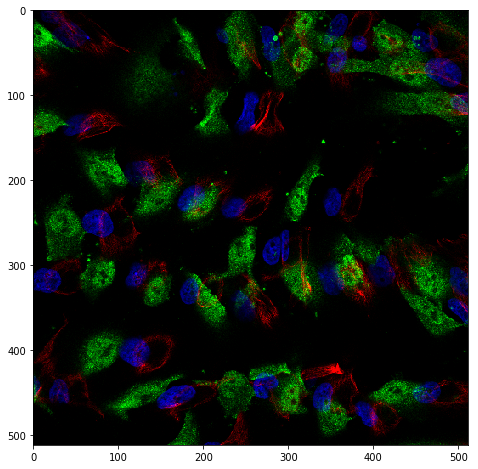

In [144]:
plt.figure(figsize=(8,8))
plt.imshow(make_rgb('6f062840-bba9-11e8-b2ba-ac1f6b6435d0', 'inputs/512_train/'))

In [148]:
df[df.Id=='6f062840-bba9-11e8-b2ba-ac1f6b6435d0']

,Id,Target,fold,weight


In [10]:
score = score_wrt_threshold(logits, targets)

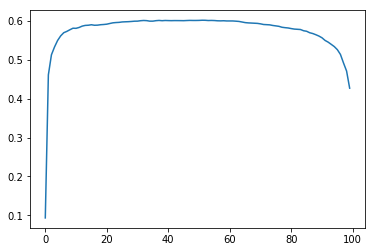

In [11]:
plt.plot(score)

In [12]:
scores = score_wrt_threshold_per_cls(logits, targets)

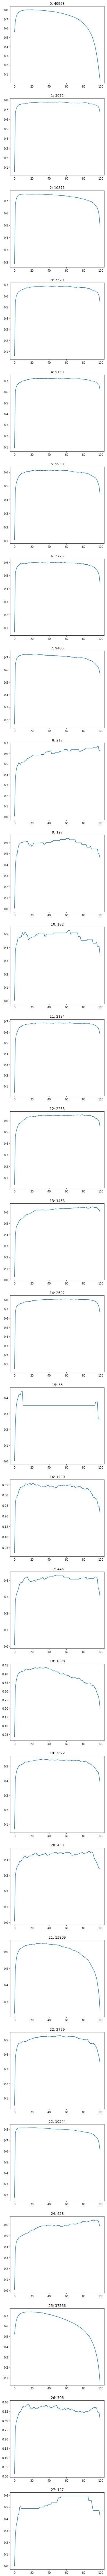

In [29]:
_, axes = plt.subplots(28,1,figsize=(6,6*28))
for c, score,ax in zip(range(28), scores,axes):
    ax.plot(score)
    ax.set_title(f'{c}: {cls_sz[c]}')

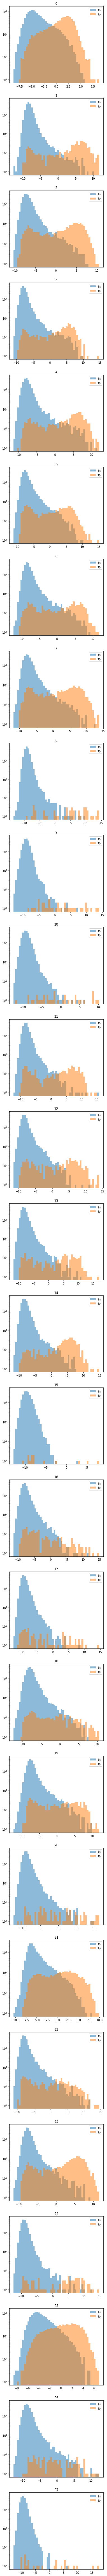

In [14]:
c_tp_vs_tn(logits, targets)

(array([6188., 1069.,  775.,  540.,  512.,  393.,  398.,  350.,  302.,
         299.,  347.,  335.,  305.,  334.,  314.,  357.,  361.,  371.,
         392.,  402.,  449.,  503.,  570.,  650.,  752.,  909., 1198.,
        1681., 2563., 9364.]),
 array([5.38336e+05, 5.42700e+03, 2.52400e+03, 1.56400e+03, 1.07900e+03,
        9.39000e+02, 6.85000e+02, 6.05000e+02, 5.18000e+02, 4.34000e+02,
        4.07000e+02, 3.32000e+02, 3.71000e+02, 3.08000e+02, 2.95000e+02,
        2.64000e+02, 2.88000e+02, 2.54000e+02, 2.58000e+02, 2.18000e+02,
        2.71000e+02, 2.51000e+02, 2.52000e+02, 2.67000e+02, 2.68000e+02,
        2.75000e+02, 2.97000e+02, 3.78000e+02, 4.51000e+02, 1.00900e+03]))

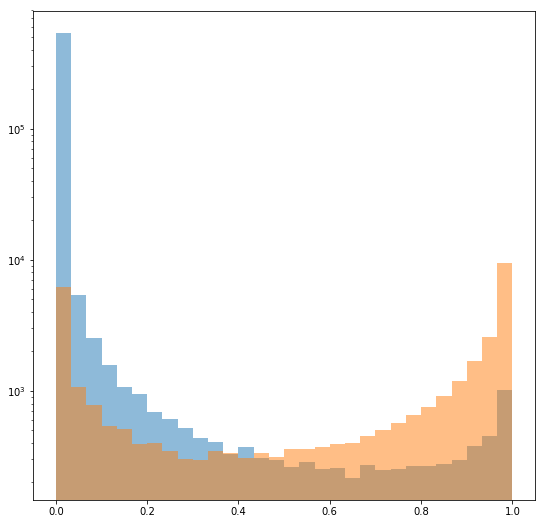

In [15]:
tp_vs_tn(logits, targets)

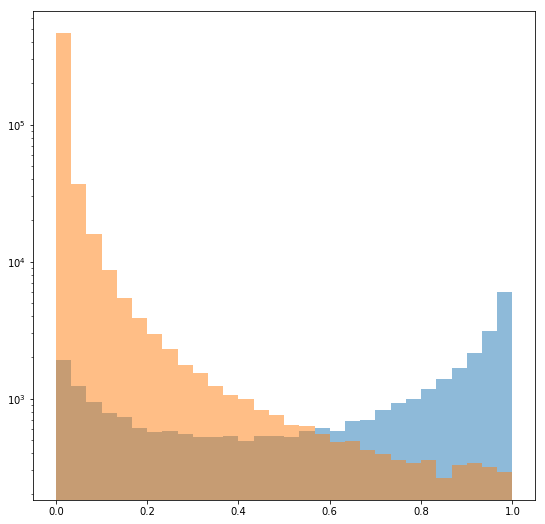

In [190]:
tp_vs_tn(model, val_dl)

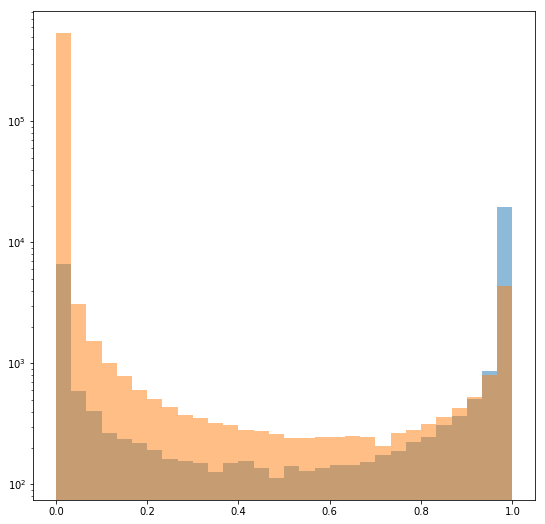

In [187]:
tp_vs_tn(model, val_dl)

In [65]:
submission = pd.read_csv('inputs/sample_submission.csv')
sz = 512
test_ds = Dataset(submission, fold=None, train=None, tsfm=TestTsfm(sz, tta=False))
test_sampler = BatchSampler(SequentialSampler(test_ds), batch_size=bs, drop_last=False)
test_dl = DataLoader(test_ds, batch_sampler=test_sampler, num_workers=3, pin_memory=True)

# lr_Find

In [20]:
lr_finder = LRFinder(model,learner.optimizer,1e-4,5,300)

In [21]:
learner.fit(1, lr_finder)

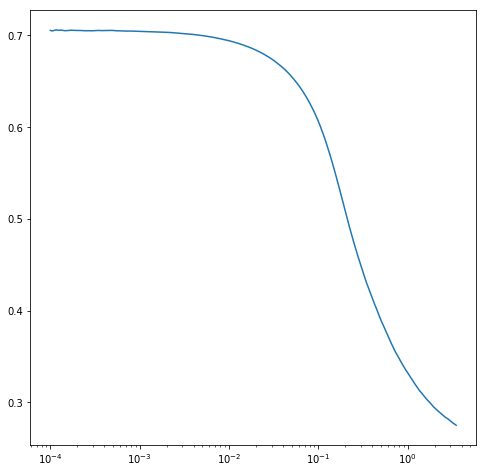

In [22]:
plt.figure(figsize=(8,8))
lr_finder.plot(0,10)

# submit

In [29]:
submission = pd.read_csv('inputs/sample_submission.csv')

In [30]:
sz = 512
test_ds = Dataset(submission, fold=None, train=None, tsfm=TestTsfm(sz))
test_sampler = BatchSampler(SequentialSampler(test_ds), batch_size=8, drop_last=False)
test_dl = DataLoader(test_ds, batch_sampler=test_sampler, num_workers=6, pin_memory=True)

In [31]:
%%time
# model = learner.model
models = []
# for fold in range(1):
#     model = Model(base=torchvision.models.resnet18).cuda()
#     model.half()
#     bn_to_float(model)
#     model.load_state_dict(torch.load(f'saved/512/hinge_f1_fold={fold}')['model'])
#     models.append(model)
# model.load_state_dict(torch.load('saved/512/pretrain_with_bce_fold=0')['model'])
models.append(model)
res = []
with torch.no_grad():
    for idx, imgs in progress_bar(zip(test_sampler, test_dl), total=len(test_dl)):
        predicts = []
        for img in imgs:
            img = img.cuda()
            for model in models:
                model.eval()
                predict = model(img)
                predict = predict.sigmoid()
                predicts.append(predict)
        weight = [1.0/8/len(models)]*(8*len(models))
#         weight = [1.0]
        weight = T(np.array(weight)).half().reshape(-1, 1, 1)
        predict = (torch.stack(predicts)*weight).sum(dim=0)
#         res.append(predict.cpu())

        predict[torch.arange(predict.shape[0]), predict.argmax(dim=1)] = 1.0
        predict = predict > 0.3
        predict = predict.cpu().numpy()
        for i, row in zip(idx, predict):
            res = ' '.join([str(p.squeeze()) for p in row.nonzero()[0]])
            submission.loc[i, 'Predicted'] = res

CPU times: user 3min 18s, sys: 32.9 s, total: 3min 51s
Wall time: 2min 19s


In [131]:
res = [each.float() for each in res]

In [132]:
res = torch.cat(res).numpy()

In [133]:
np.save('f1_loss.npy', res)

In [134]:
f1_loss = np.load('f1_loss.npy')

In [32]:
submission.to_csv('submission.csv', index=False)

# visualize

In [173]:
ds = Dataset(df, fold=0, train=True, tsfm=Tsfm(512))

In [174]:
def tsfm_contrast(ds, aug):
    row = 2
    column = 2
    img_sz = 8
    _, axes = plt.subplots(row,column,figsize=(img_sz*column,img_sz*row))
    for row in axes:
        i = np.random.randint(0, len(ds))
        img = ds[i][0]
        row[0].imshow(img[:,:,:3])
        auged_img = aug(image=img)['image']
        row[1].imshow(auged_img[:,:,:3])

In [175]:
aug = Compose([
    IAAPerspective(p=0.75),
#         ShiftScaleRotate(rotate_limit=0, shift_limit=.1, scale_limit=0, border_mode=cv2.BORDER_CONSTANT),
#         ShiftScaleRotate(rotate_limit=45, shift_limit=.0, scale_limit=0, border_mode=cv2.BORDER_CONSTANT),
#         ShiftScaleRotate(rotate_limit=0, shift_limit=.0, scale_limit=0.1, border_mode=cv2.BORDER_CONSTANT),
    ShiftScaleRotate(rotate_limit=45, shift_limit=.1, scale_limit=0.1,
                     border_mode=cv2.BORDER_CONSTANT, p=0.75),
], p=1)

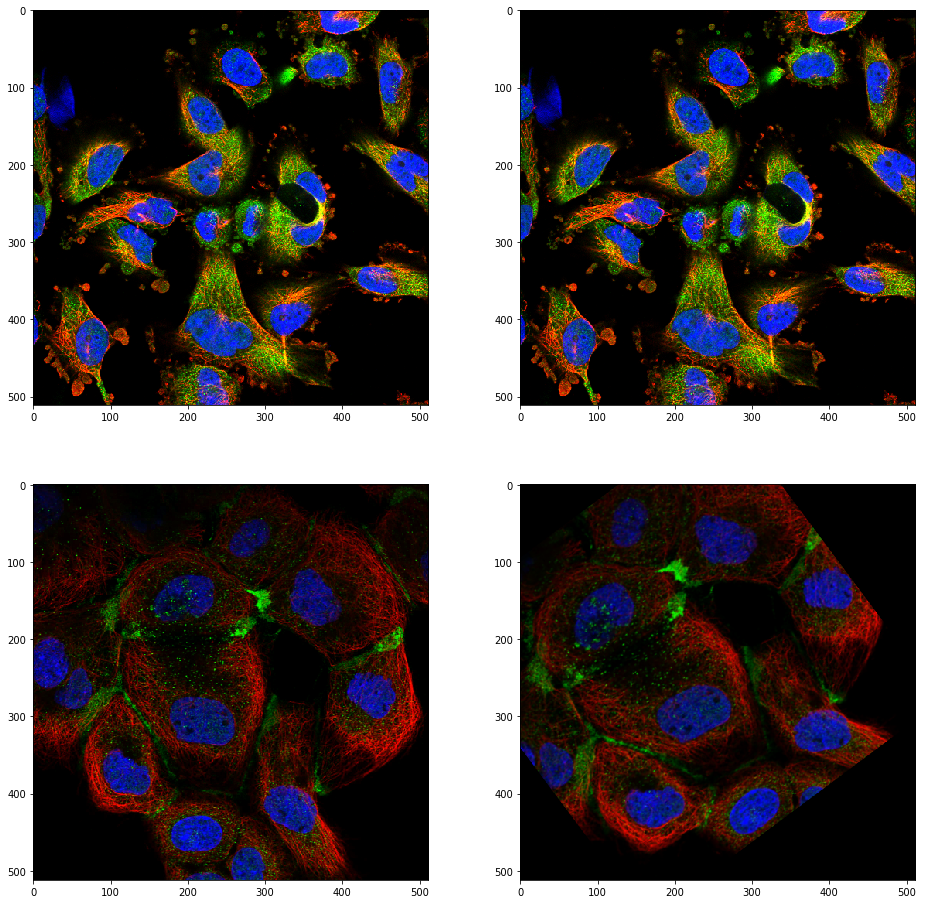

In [178]:
tsfm_contrast(ds, aug)

In [128]:
img = cv2.imread('temp.jpg')

In [129]:
aug = IAAPerspective(p=1)

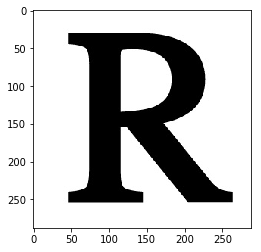

In [131]:
plt.imshow(img)

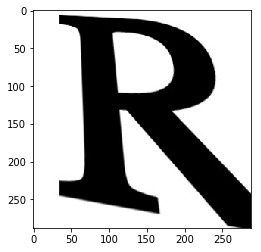

In [142]:
plt.imshow(aug(image=img)['image'])